Mounting Google Drive

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive /Colab Notebooks/Session 7')

In [ ]:
pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torchvision

Updating Device to CUDA

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu") #c2

CUDA Available? True


Importing custom modules

In [21]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [40]:
import utils
import model

In [39]:
from utils import *

In [7]:
from model import (F,
  Net,
  nn,
  torch)

Defining data tranformations

In [8]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation((-10., 10.), fill=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


Downloading MNIST dataset and splitting to train and test set

In [10]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 48730448.25it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Creating Data Loaders from train data and test data

In [11]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

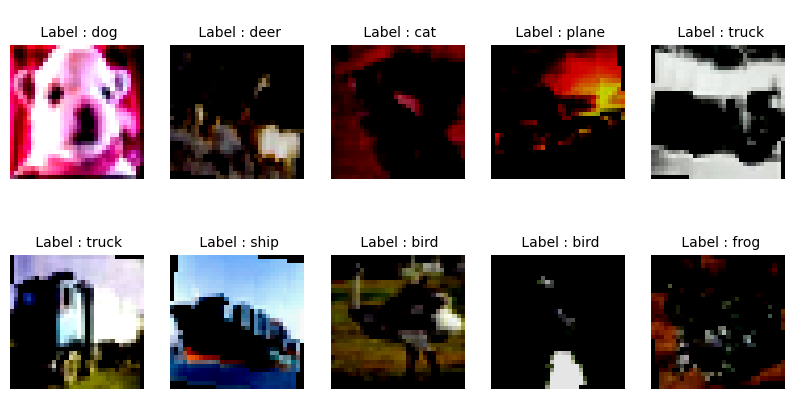

In [23]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
num_of_images = 10
fig = plt.figure(figsize=(10,5))

for index in range(1, num_of_images+1):
    ax = fig.add_subplot(2, 5, index)
    ax.axis('off')
    actual = classes[labels[index]]
    ax.set_title(f'\n Label : {actual}',fontsize=10)
    ax.imshow(np.transpose(images[index], (1, 2, 0)))

## Data Statistics

Transferring model to GPU and printing model summary

In [12]:
model1 = Net(norm= "GN").to(device)
summary(model1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
              ReLU-6           [-1, 16, 32, 32]               0
         GroupNorm-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 10, 32, 32]             160
        MaxPool2d-10           [-1, 10, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,440
             ReLU-12           [-1, 16, 16, 16]               0
        GroupNorm-13           [-1, 16, 16, 16]              32
          Dropout-14           [-1, 16,

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Training and evaluating the model with BatchNorm2d layers

In [14]:
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20

#scheduler = StepLR(optimizer, step_size=6, gamma=0.10)
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model1, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model1, device, test_loader)

EPOCH: 1


Loss=1.375131368637085 Batch_id=390 Accuracy=34.63: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]



Test set: Average loss: 1.5590, Accuracy: 4392/10000 (43.92%)

EPOCH: 2


Loss=1.3653557300567627 Batch_id=390 Accuracy=48.18: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]



Test set: Average loss: 1.3187, Accuracy: 5124/10000 (51.24%)

EPOCH: 3


Loss=1.1159818172454834 Batch_id=390 Accuracy=54.65: 100%|██████████| 391/391 [00:56<00:00,  6.89it/s]



Test set: Average loss: 1.1385, Accuracy: 5925/10000 (59.25%)

EPOCH: 4


Loss=1.1738030910491943 Batch_id=390 Accuracy=59.11: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 1.1170, Accuracy: 5907/10000 (59.07%)

EPOCH: 5


Loss=1.0460076332092285 Batch_id=390 Accuracy=61.66: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]



Test set: Average loss: 1.0474, Accuracy: 6358/10000 (63.58%)

EPOCH: 6


Loss=0.6931209564208984 Batch_id=390 Accuracy=64.17: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]



Test set: Average loss: 0.9515, Accuracy: 6592/10000 (65.92%)

EPOCH: 7


Loss=1.2545548677444458 Batch_id=390 Accuracy=65.79: 100%|██████████| 391/391 [00:45<00:00,  8.54it/s]



Test set: Average loss: 0.9418, Accuracy: 6669/10000 (66.69%)

EPOCH: 8


Loss=0.8596307039260864 Batch_id=390 Accuracy=67.01: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 0.9421, Accuracy: 6675/10000 (66.75%)

EPOCH: 9


Loss=0.8240584135055542 Batch_id=390 Accuracy=68.32: 100%|██████████| 391/391 [00:46<00:00,  8.45it/s]



Test set: Average loss: 0.8527, Accuracy: 7012/10000 (70.12%)

EPOCH: 10


Loss=0.9005426168441772 Batch_id=390 Accuracy=69.26: 100%|██████████| 391/391 [00:50<00:00,  7.71it/s]



Test set: Average loss: 0.8277, Accuracy: 7105/10000 (71.05%)

EPOCH: 11


Loss=0.856594443321228 Batch_id=390 Accuracy=70.34: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]



Test set: Average loss: 0.8056, Accuracy: 7163/10000 (71.63%)

EPOCH: 12


Loss=0.6500087976455688 Batch_id=390 Accuracy=71.17: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]



Test set: Average loss: 0.7880, Accuracy: 7232/10000 (72.32%)

EPOCH: 13


Loss=0.7593687176704407 Batch_id=390 Accuracy=71.87: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]



Test set: Average loss: 0.8000, Accuracy: 7145/10000 (71.45%)

EPOCH: 14


Loss=0.6189643144607544 Batch_id=390 Accuracy=72.08: 100%|██████████| 391/391 [00:45<00:00,  8.59it/s]



Test set: Average loss: 0.7863, Accuracy: 7252/10000 (72.52%)

EPOCH: 15


Loss=0.8760132789611816 Batch_id=390 Accuracy=72.98: 100%|██████████| 391/391 [00:45<00:00,  8.65it/s]



Test set: Average loss: 0.7717, Accuracy: 7337/10000 (73.37%)

EPOCH: 16


Loss=0.7642956972122192 Batch_id=390 Accuracy=73.59: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]



Test set: Average loss: 0.7287, Accuracy: 7387/10000 (73.87%)

EPOCH: 17


Loss=0.7426759004592896 Batch_id=390 Accuracy=74.08: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]



Test set: Average loss: 0.7262, Accuracy: 7452/10000 (74.52%)

EPOCH: 18


Loss=0.7309990525245667 Batch_id=390 Accuracy=74.42: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]



Test set: Average loss: 0.7115, Accuracy: 7522/10000 (75.22%)

EPOCH: 19


Loss=0.5871677398681641 Batch_id=390 Accuracy=74.63: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]



Test set: Average loss: 0.7271, Accuracy: 7452/10000 (74.52%)

EPOCH: 20


Loss=0.5074515342712402 Batch_id=390 Accuracy=75.19: 100%|██████████| 391/391 [00:45<00:00,  8.64it/s]



Test set: Average loss: 0.7192, Accuracy: 7498/10000 (74.98%)



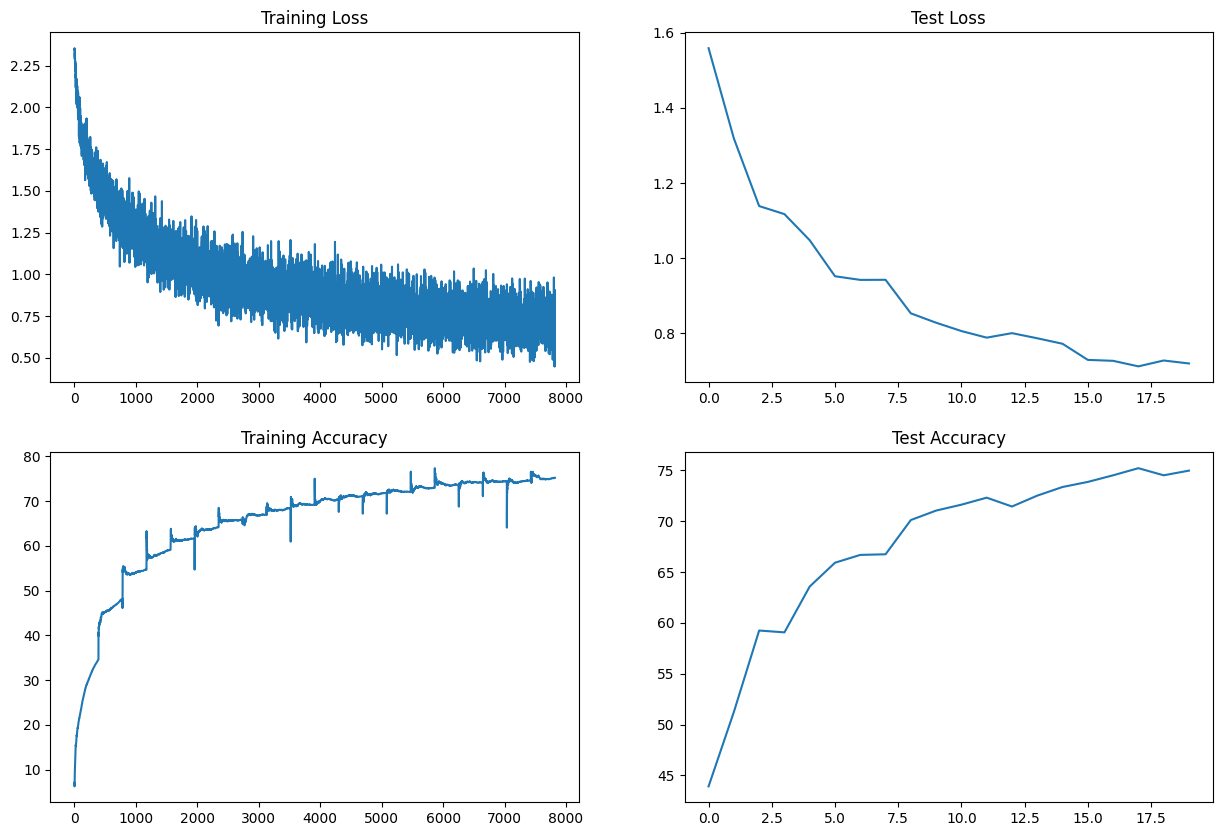

In [15]:
train_losses = [t_items.item() for t_items in train_losses]
plot_graphs(train_losses, train_acc, test_losses ,test_acc)

In [28]:
wrong_prediction_list = []
model1.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model1(images)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    match = pred.eq(labels.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(match):
        if(i == False):
            wrong_prediction_list.append((images[j], pred[j].item(), labels[j].item()))

In [37]:
display_incorrect_images(wrong_prediction_list, n=10 )

AttributeError: ignored

# Target:

To achieve consistent 70% test accuracy with GroupNorm

# Results:
Parameters: 35,504

Best Training Accuracy: 75.18

Best Test Accuracy: 72.48

# Analysis:

Model is training well. Desired accuracy achieved from 7th epoch
Learning rate started from 0.2 and stepped down at every 6th epoch.